In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
treekwargs = dict(
    weights=['xsecWeight/1000','genWeight','puWeight'],
    treename='Events',
    normalization=None,
)

base = fc.fs.cernbox.fullpath('/eos/user/e/ekoenig/Ntuples/NanoHH4b/run2/mindiag_2018_0L')

f_sig = f'{base}/mc/ggHH4b_tree.root'
signal = ObjIter([Tree( f_sig, **treekwargs)])

f_qcd = f'{base}/mc/qcd-mg_tree.root'
bkg = ObjIter([Tree( f_qcd, **treekwargs)])

100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


In [3]:
kfold_bdt = KFoldBDTClassifier(
    features=['dHH_H1_regmass','dHH_H1_regpt','dHH_H2_regmass', 'dHH_H2_regpt'] 
)

In [4]:
@cache_variable(bins=(0,100,30))
def h_dm(t):
    return np.sqrt( (t.dHH_H1_regmass - 125)**2 + (t.dHH_H2_regmass - 120)**2 )

    
@cache_variable
def n_loose_btag(t):
    nL = 1*t.ak4_h1b1_btag_L + 1*t.ak4_h1b2_btag_L + 1*t.ak4_h2b1_btag_L + 1*t.ak4_h2b2_btag_L
    return ak.values_astype(nL, np.int32)

In [6]:
sr = EventFilter('sr', filter=lambda t : (n_loose_btag(t) == 4), verbose=True)
signal = signal.apply(sr)
bkg = bkg.apply(sr)

ggHH4b sr eff: 6.22e-01
qcd-mg sr eff: 3.05e-01


In [7]:
kfold_bdt.train(bkg, signal)

In [8]:
kfold_bdt.print_results(bkg, signal)

--- BDT Classifier Results ---
AUROC = 0.891


In [9]:
sig_weights = signal.scale.cat * lumiMap[2018][0]
sig_index = signal.apply(lambda t : np.arange(len(t)) % 2).cat
sig_bdt_0_score = signal.apply(kfold_bdt.bdts[0].predict_tree).cat
sig_bdt_1_score = signal.apply(kfold_bdt.bdts[1].predict_tree).cat

bkg_weights = bkg.scale.cat * lumiMap[2018][0]
bkg_index = bkg.apply(lambda t : np.arange(len(t)) % 2).cat
bkg_bdt_0_score = bkg.apply(kfold_bdt.bdts[0].predict_tree).cat
bkg_bdt_1_score = bkg.apply(kfold_bdt.bdts[1].predict_tree).cat

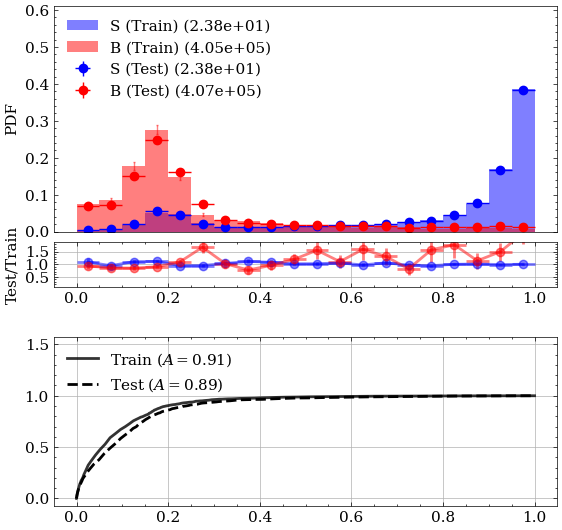

In [10]:
# trained discriminant C0 in train/test samples
fig, _, _ = hist_multi(
    [sig_bdt_0_score[sig_index != 0], bkg_bdt_0_score[bkg_index != 0], sig_bdt_0_score[sig_index == 0], bkg_bdt_0_score[bkg_index == 0]],
    weights = [sig_weights[sig_index != 0], bkg_weights[bkg_index != 0], sig_weights[sig_index == 0], bkg_weights[bkg_index == 0]],
    bins=(0, 1, 21), stacked=False,
    is_data = [False, False, True, True],
    h_label=['S (Train)', 'B (Train)', 'S (Test)', 'B (Test)'],
    h_color=['blue', 'red', 'blue', 'red'],
    h_alpha=[0.5, 0.5, 1.0, 1.0],
    h_histtype=['stepfilled', 'stepfilled', None, None],
    efficiency=True, legend=True,

    ratio=True, r_group=((0, 2), (1, 3)), r_ylabel='Test/Train',
    
    empirical=True, e_show=False,
    e_correlation=True, e_c_method='roc', e_c_group=[(2,3), (0,1)],
    e_c_o_label=['Train','Test'],
    e_c_o_linestyle=['-','--'],
    e_c_o_color='black',
    e_c_o_alpha=[0.8, 1.0],
    e_c_label_stat='area',
)